# Import Packages

In [1]:
import torch
from torch import nn
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import time
import numpy as np
import matplotlib.pyplot as plt
from torchvision.ops import FeaturePyramidNetwork
import torch.nn.functional as F
from torchvision.ops import FeaturePyramidNetwork

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function of Display Training Progress

In [2]:
# plot 4 metrics during training progress
def plot_training_progress(results_path):
    data = torch.load(results_path)
    fig, ax1 = plt.subplots()
    plt.plot(data["train_loss"], 'r', label = 'train_loss')
    plt.plot(data["val_loss"], 'm', label = 'val_loss')
    plt.legend(loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')

    ax2=ax1.twinx()
    plt.plot(data["train_accuracy"], 'g', label = 'train_accuracy')
    plt.plot(data["val_accuracy"], 'b', label = 'val_accuracy')
    plt.legend(loc='lower right')
    ax2.set_ylabel('accuracy')

    plt.show()

# Dataset Defination

In [5]:
# Transformations for Training, includes data augmentation
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop the image to 224x224 pixels while keeping aspect ratio
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change the brightness, contrast and saturation of the image
    transforms.RandomRotation(10),  # Randomly rotate the image within the range of (-10. +10) degrees
    transforms.ToTensor(),  # Convert PIL Image or numpy.ndarray to tensor, and normalize to [0-1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize to [-1, 1], mean and std deviation are from ImageNet
])

# Transformations for Validation and Testing, no data augmentation
transform_test_and_val = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image with precomputed ImageNet mean and std deviation
])

train_dataset = ImageFolder(root="./MO_106_train", transform=transform_train)
val_dataset = ImageFolder(root="./MO_106_val", transform=transform_test_and_val)
test_dataset = ImageFolder(root="./MO_106_test", transform=transform_test_and_val)



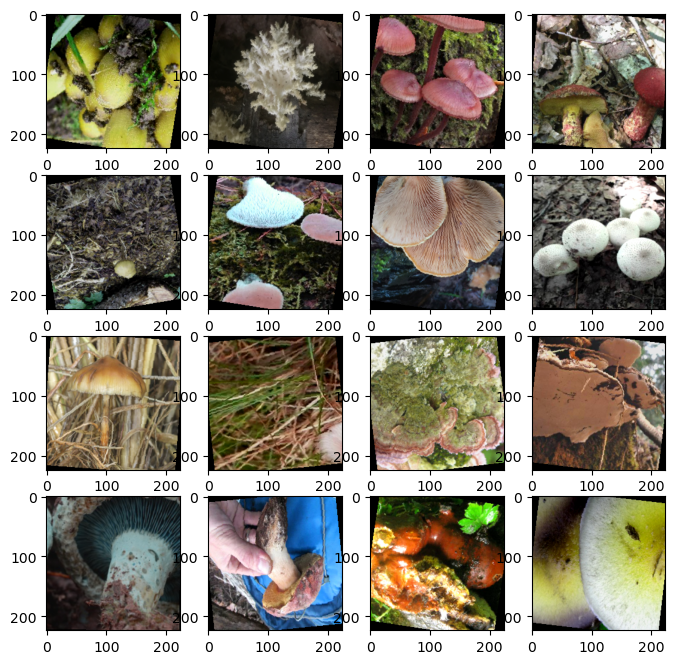

In [6]:
import matplotlib.pyplot as plt

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # 转换成numpy数组，然后转换通道顺序
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    img = img * std + mean  # 逆归一化
    img = img.clip(0, 1)  # 确保图像数据在[0,1]范围内
    plt.imshow(img)

# 从训练集中选择若干张图片
images, _ = next(iter(DataLoader(train_dataset, batch_size=16, shuffle=True)))

# 绘制图片
fig = plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    imshow(images[i])

plt.show()


# ResNet - No Image Augmentation

In [20]:
# 定义 ResNet 模型
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()

        # 加载预训练的 ResNet 模型
        self.backbone = resnet50(pretrained=True)

        # 替换最后的全连接层
        self.backbone.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x
    
# time recording start
start_time = time.time()

# # 定义数据预处理
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # 加载数据集
# dataset = ImageFolder(root="./MO_106/", transform=transform)

# # 数据集分割为训练集、验证集和测试集
# train_size = int(0.7 * len(dataset))
# val_size = int(0.2 * len(dataset))
# test_size = len(dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Training loop
num_epochs = 20
batch_size = 150
lr = 0.0003

# 分别创建训练集、验证集和测试集的 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

# 定义模型
model = ResNet(num_classes=106)
model = model.to(device)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

# 训练模型
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/10], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # 在每个 epoch 后使用验证集评估模型
    model.eval()
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)
    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"resnet_noaug_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)
        
# 所有训练完成后，使用测试集进行最后的评估
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test accuracy: {correct / total * 100}%')


Epoch 1/20: Train Loss: 2.8736, Train Accuracy: 0.3095, Val Loss: 2.0505, Val Accuracy: 0.4479
Epoch 2/20: Train Loss: 1.9162, Train Accuracy: 0.4914, Val Loss: 1.8192, Val Accuracy: 0.5005
Epoch 3/20: Train Loss: 1.6248, Train Accuracy: 0.5598, Val Loss: 1.4873, Val Accuracy: 0.5853
Epoch 4/20: Train Loss: 1.4277, Train Accuracy: 0.6096, Val Loss: 1.3769, Val Accuracy: 0.6171
Epoch 5/20: Train Loss: 1.3499, Train Accuracy: 0.6288, Val Loss: 1.3701, Val Accuracy: 0.6140
Epoch 6/20: Train Loss: 1.2159, Train Accuracy: 0.6642, Val Loss: 1.2400, Val Accuracy: 0.6493
Epoch 7/20: Train Loss: 1.1469, Train Accuracy: 0.6798, Val Loss: 1.2539, Val Accuracy: 0.6553
Epoch 8/20: Train Loss: 1.0942, Train Accuracy: 0.6913, Val Loss: 1.2038, Val Accuracy: 0.6687
Epoch 9/20: Train Loss: 1.0284, Train Accuracy: 0.7113, Val Loss: 1.2083, Val Accuracy: 0.6735
Epoch 10/20: Train Loss: 0.9751, Train Accuracy: 0.7224, Val Loss: 1.1629, Val Accuracy: 0.6863
Epoch 11/20: Train Loss: 0.9367, Train Accuracy: 

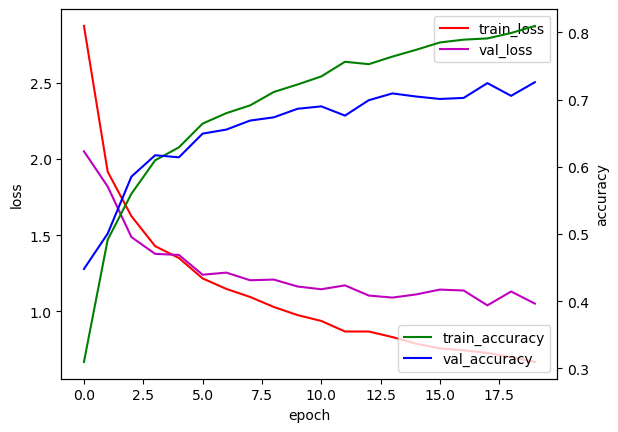

In [21]:
plot_training_progress(results_path)

Precision: 0.7332
Recall: 0.7031
F1 Score: 0.6993


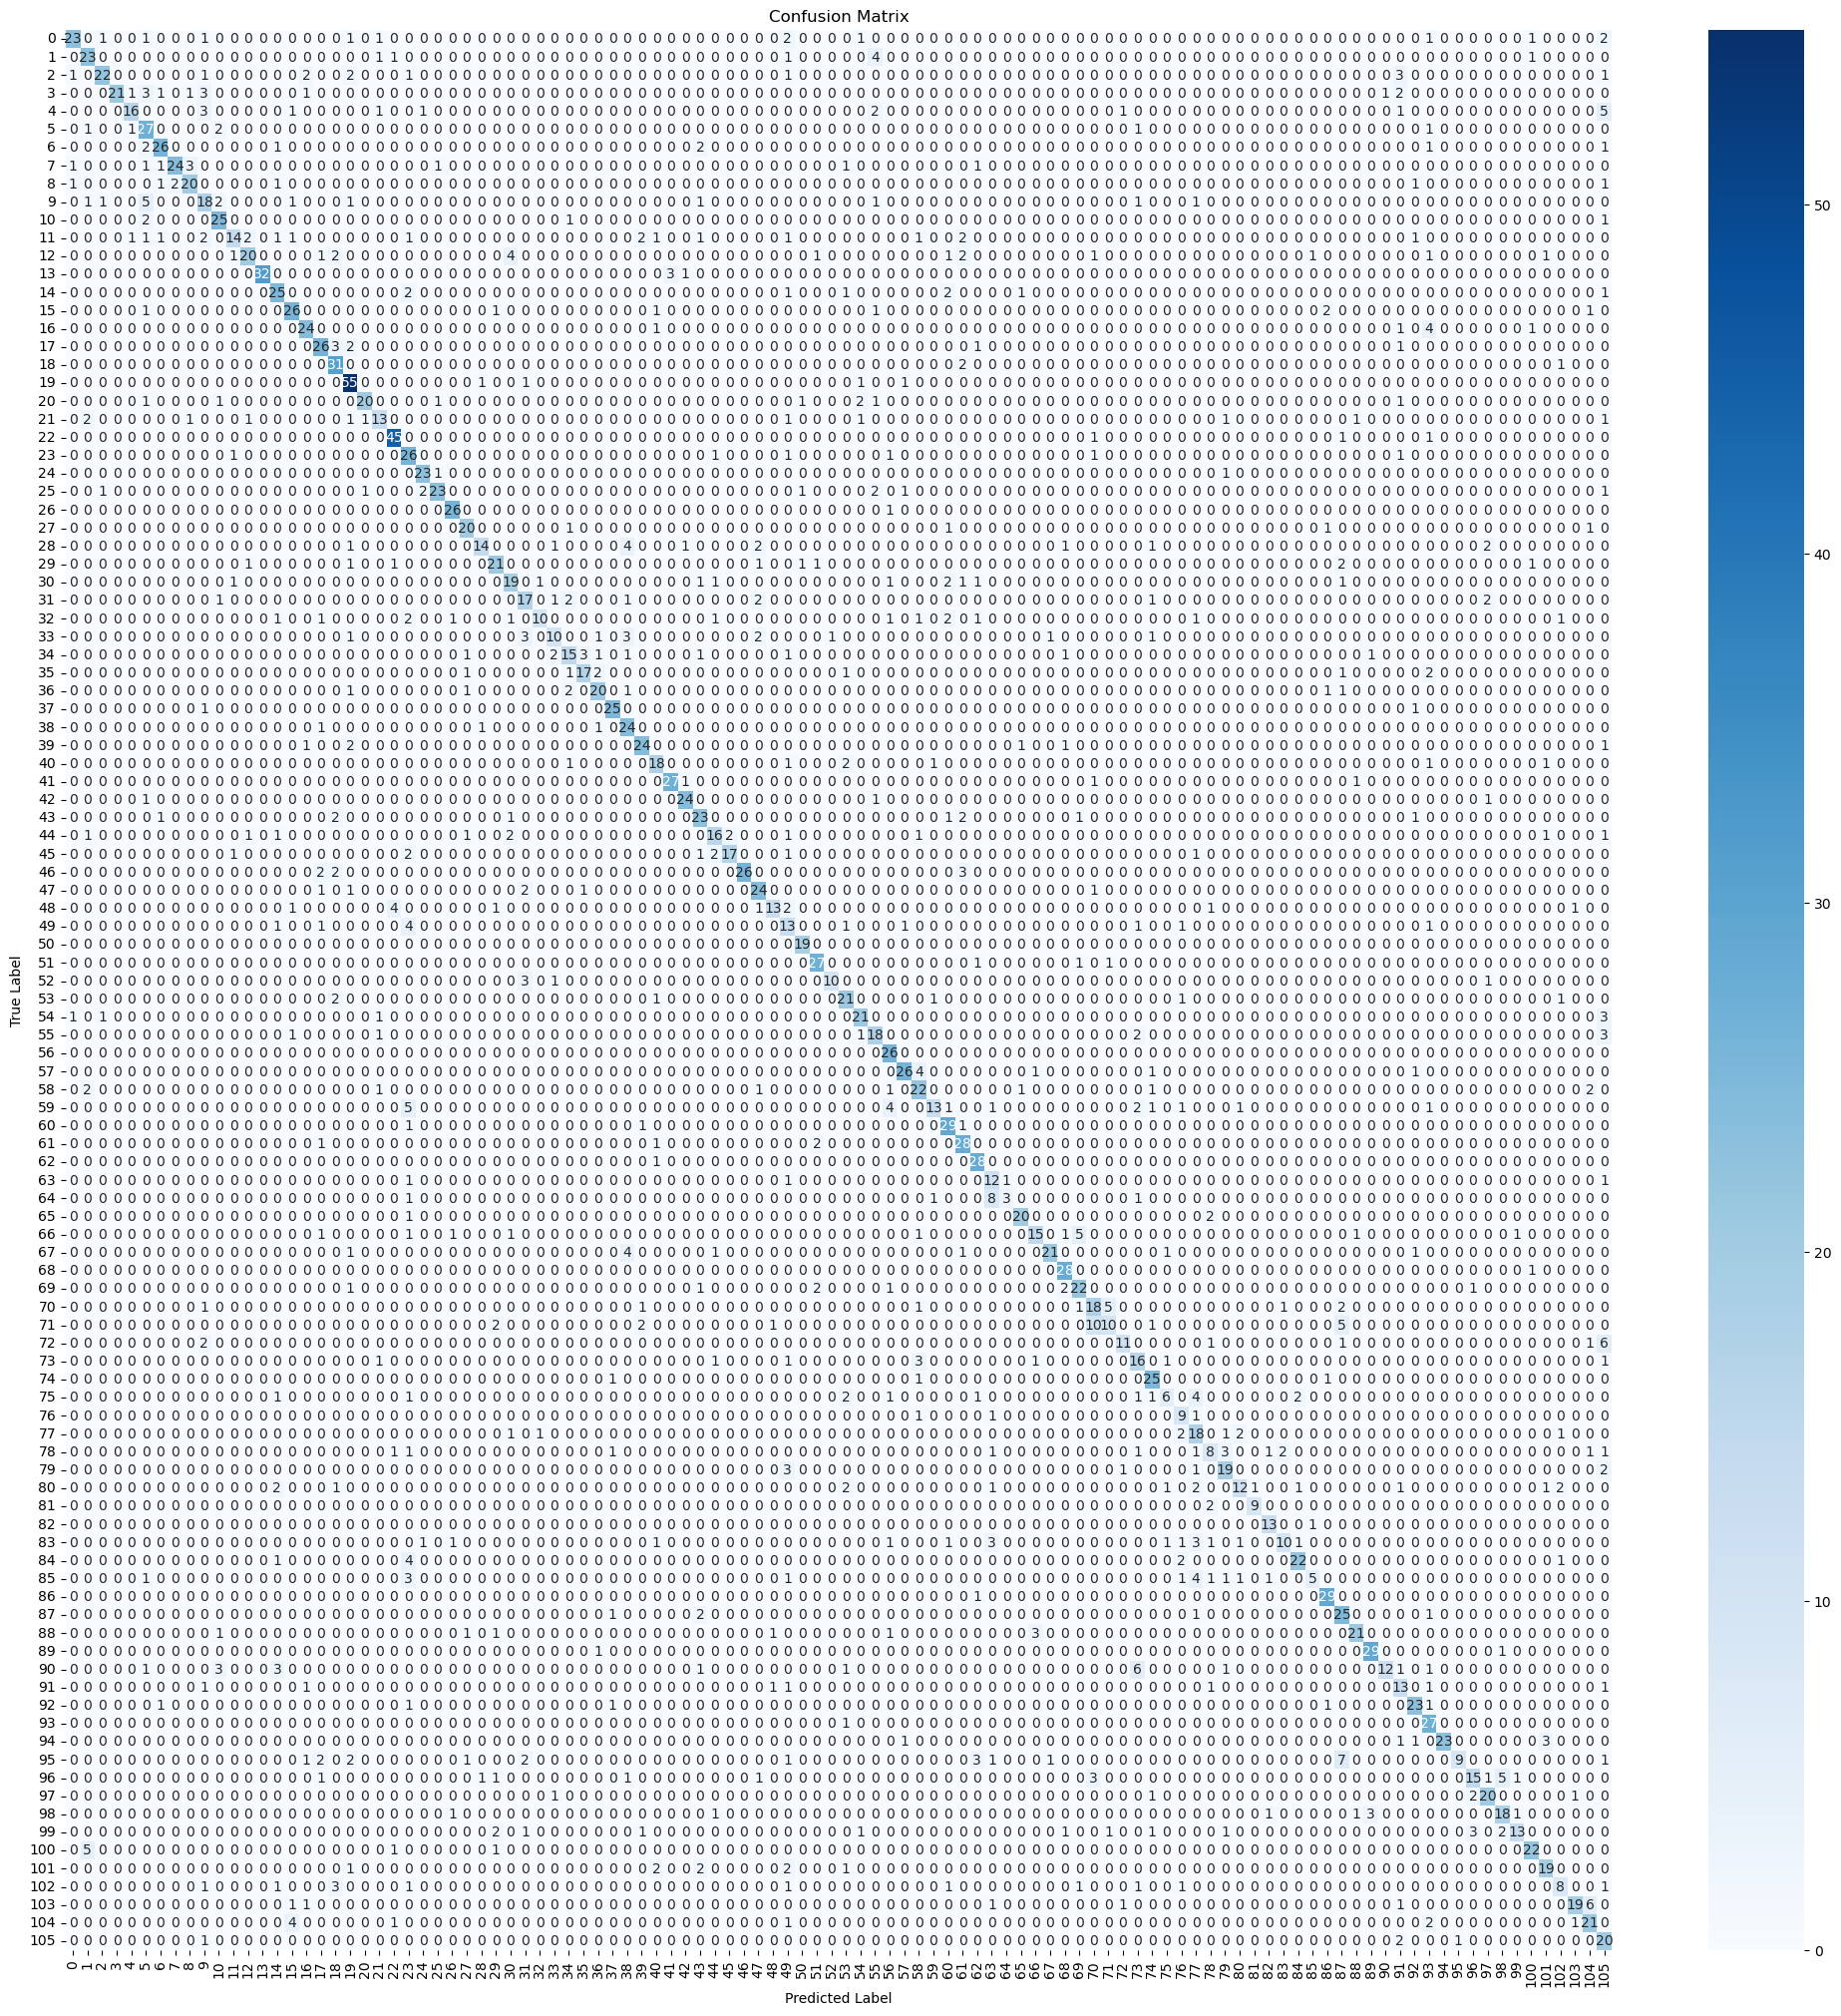

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 加载模型
model = ResNet(num_classes=106)
model.load_state_dict(torch.load(results_path)['model_state_dict'])
model = model.to(device)

# 设置模型为评估模式
model.eval()

# 初始化预测和真实标签的列表
y_true = []
y_pred = []

# 使用模型进行预测
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_true.extend(labels.cpu().numpy().tolist())

# 计算评价指标
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 计算混淆矩阵并进行可视化
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# ResNet - With Image Augmentation

In [10]:
torch.cuda.empty_cache()
# 定义 ResNet 模型
class ResNet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()

        # 加载预训练的 ResNet 模型
        self.backbone = resnet50(pretrained=True)

        # 替换最后的全连接层
        self.backbone.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x
    
# time recording start
start_time = time.time()

# Training loop
num_epochs = 20
batch_size = 150
lr = 0.0005

# 分别创建训练集、验证集和测试集的 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定义模型
model = ResNet(num_classes=106)
model = model.to(device)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

# 训练模型
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/10], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # 在每个 epoch 后使用验证集评估模型
    model.eval()
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)
    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"resnet_aug_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)
        
# 所有训练完成后，使用测试集进行最后的评估
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test accuracy: {correct / total * 100}%')


c:\ProgramData\Anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20: Train Loss: 2.9760, Train Accuracy: 0.2742, Val Loss: 2.5484, Val Accuracy: 0.3512
Epoch 2/20: Train Loss: 2.1799, Train Accuracy: 0.4264, Val Loss: 2.3317, Val Accuracy: 0.4140
Epoch 3/20: Train Loss: 1.8620, Train Accuracy: 0.5016, Val Loss: 1.7966, Val Accuracy: 0.5046
Epoch 4/20: Train Loss: 1.7062, Train Accuracy: 0.5386, Val Loss: 1.7776, Val Accuracy: 0.5107
Epoch 5/20: Train Loss: 1.5460, Train Accuracy: 0.5763, Val Loss: 1.5811, Val Accuracy: 0.5604
Epoch 6/20: Train Loss: 1.4422, Train Accuracy: 0.5992, Val Loss: 1.5061, Val Accuracy: 0.5829
Epoch 7/20: Train Loss: 1.3539, Train Accuracy: 0.6250, Val Loss: 1.6506, Val Accuracy: 0.5545
Epoch 8/20: Train Loss: 1.2792, Train Accuracy: 0.6450, Val Loss: 1.4434, Val Accuracy: 0.6065
Epoch 9/20: Train Loss: 1.2266, Train Accuracy: 0.6575, Val Loss: 1.4483, Val Accuracy: 0.6113
Epoch 10/20: Train Loss: 1.1710, Train Accuracy: 0.6677, Val Loss: 1.3052, Val Accuracy: 0.6471
Epoch 11/20: Train Loss: 1.1086, Train Accuracy: 

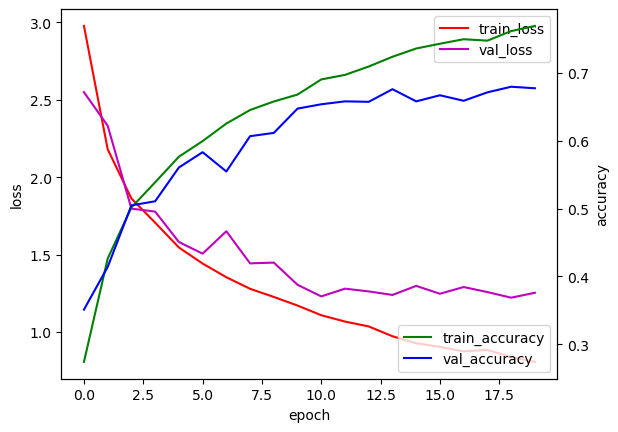

In [11]:
plot_training_progress(results_path)

Precision: 0.7026
Recall: 0.6693
F1 Score: 0.6690


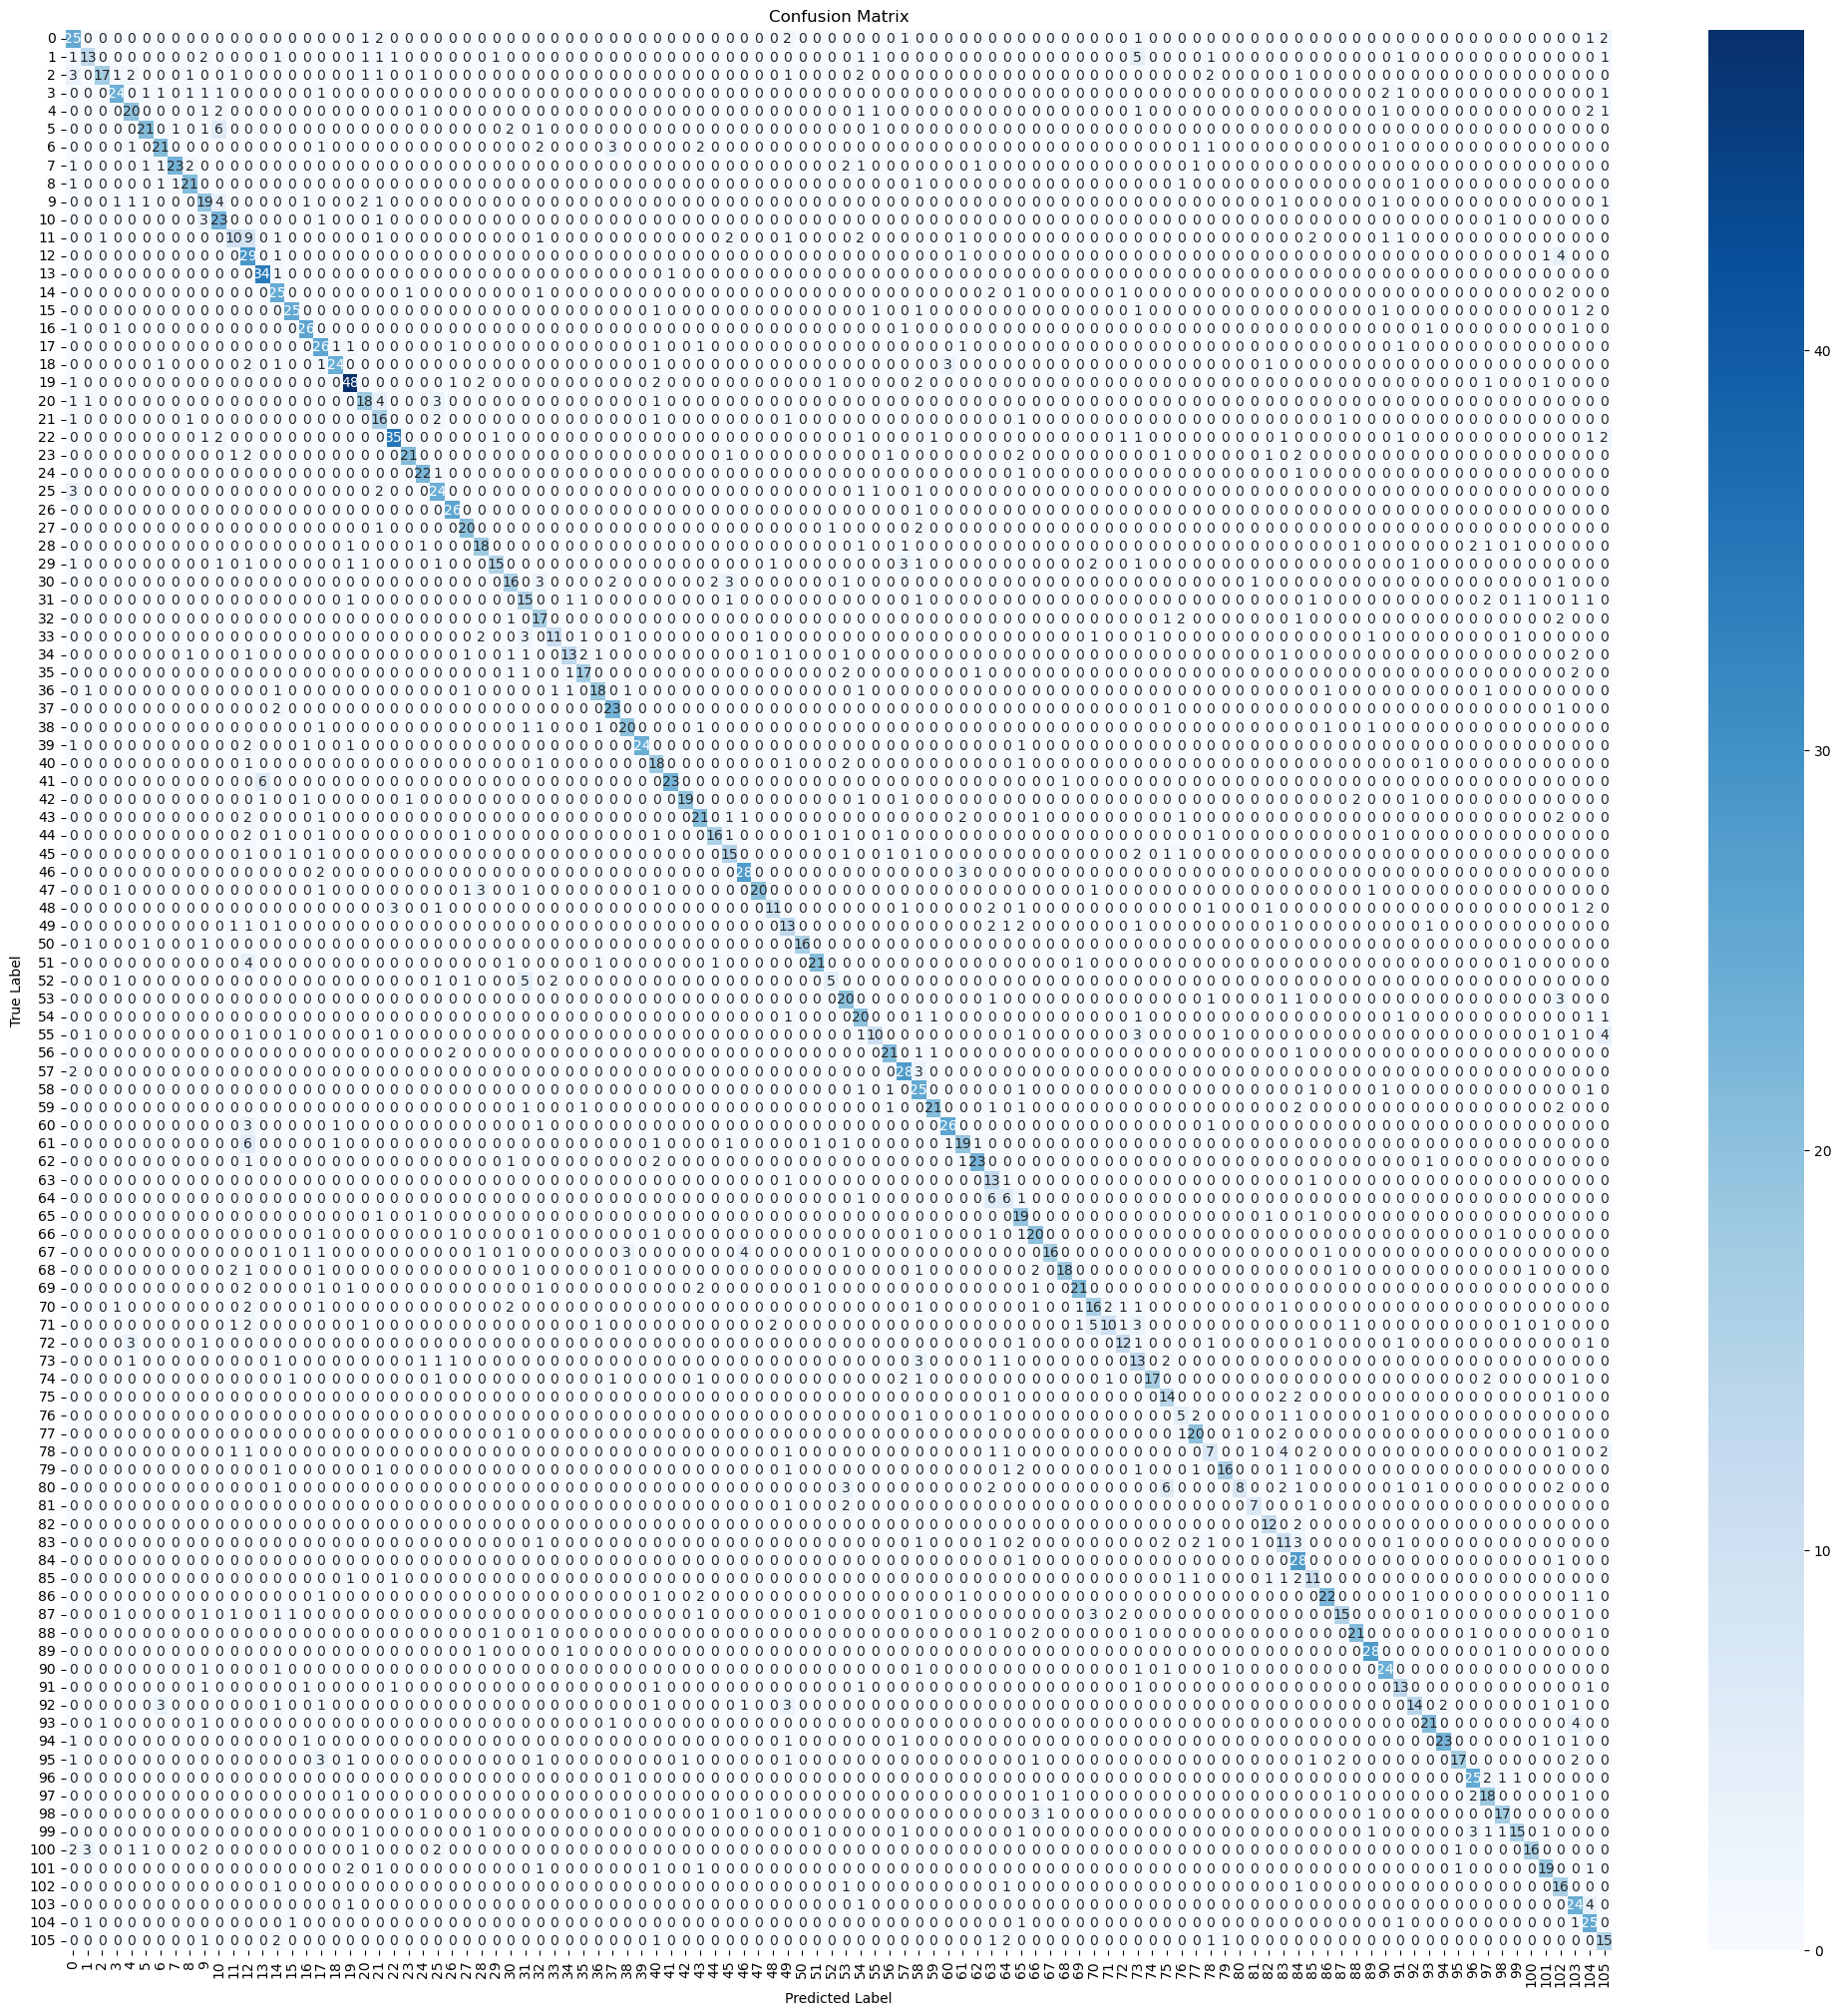

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 加载模型
model = ResNet(num_classes=106)
model.load_state_dict(torch.load(results_path)['model_state_dict'])
model = model.to(device)

# 设置模型为评估模式
model.eval()

# 初始化预测和真实标签的列表
y_true = []
y_pred = []

# 使用模型进行预测
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_true.extend(labels.cpu().numpy().tolist())

# 计算评价指标
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 计算混淆矩阵并进行可视化
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# ResNet - With Image Augmentation - Featurized Image Pyramid

In [13]:
torch.cuda.empty_cache()
class ResNetFIP(nn.Module):
    def __init__(self, num_classes):
        super(ResNetFIP, self).__init__()
        
        # 加载预训练的ResNet模型
        self.backbone = resnet50(pretrained=True)
        
        # 获取ResNet中的不同层的输出大小
        self.conv1 = self.backbone.conv1
        self.bn1 = self.backbone.bn1
        self.relu = self.backbone.relu
        self.maxpool = self.backbone.maxpool
        self.layer1 = self.backbone.layer1
        self.layer2 = self.backbone.layer2
        self.layer3 = self.backbone.layer3
        self.layer4 = self.backbone.layer4
        
        # 使用Feature Pyramid Network
        self.fpn = FeaturePyramidNetwork(in_channels_list=[256, 512, 1024, 2048],
                                          out_channels=256)
        
        # 分类层
        self.fc1 = nn.Linear(256, num_classes)
        self.fc2 = nn.Linear(256, num_classes)
        self.fc3 = nn.Linear(256, num_classes)
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        # ResNet部分
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        
        # FPN部分
        features = self.fpn({"0": x1, "1": x2, "2": x3, "3": x4})
        
        # 分类部分
        out1 = self.fc1(F.adaptive_avg_pool2d(features["0"], (1, 1)).view(x.size(0), -1))
        out2 = self.fc2(F.adaptive_avg_pool2d(features["1"], (1, 1)).view(x.size(0), -1))
        out3 = self.fc3(F.adaptive_avg_pool2d(features["2"], (1, 1)).view(x.size(0), -1))
        out4 = self.fc4(F.adaptive_avg_pool2d(features["3"], (1, 1)).view(x.size(0), -1))
        
        out = out1 + out2 + out3 + out4
        
        return out

    
# time recording start
start_time = time.time()

# Training loop
num_epochs = 20
batch_size = 128
lr = 0.00005

# 分别创建训练集、验证集和测试集的 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定义模型
model = ResNetFIP(num_classes=106)
model = model.to(device)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

# 训练模型
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/10], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # 在每个 epoch 后使用验证集评估模型
    model.eval()
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)
    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"resnet_aug_fip_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)
        
# 所有训练完成后，使用测试集进行最后的评估
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test accuracy: {correct / total * 100}%')


c:\ProgramData\Anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20: Train Loss: 3.0180, Train Accuracy: 0.2915, Val Loss: 1.7641, Val Accuracy: 0.5046
Epoch 2/20: Train Loss: 1.7774, Train Accuracy: 0.5198, Val Loss: 1.3374, Val Accuracy: 0.6235
Epoch 3/20: Train Loss: 1.4353, Train Accuracy: 0.6051, Val Loss: 1.2174, Val Accuracy: 0.6541
Epoch 4/20: Train Loss: 1.2401, Train Accuracy: 0.6534, Val Loss: 1.1453, Val Accuracy: 0.6682
Epoch 5/20: Train Loss: 1.1073, Train Accuracy: 0.6891, Val Loss: 1.1273, Val Accuracy: 0.6799
Epoch 6/20: Train Loss: 1.0242, Train Accuracy: 0.7069, Val Loss: 1.0286, Val Accuracy: 0.7073
Epoch 7/20: Train Loss: 0.9248, Train Accuracy: 0.7384, Val Loss: 1.0178, Val Accuracy: 0.7159
Epoch 8/20: Train Loss: 0.8715, Train Accuracy: 0.7527, Val Loss: 1.0141, Val Accuracy: 0.7145
Epoch 9/20: Train Loss: 0.8030, Train Accuracy: 0.7721, Val Loss: 1.0116, Val Accuracy: 0.7178
Epoch 10/20: Train Loss: 0.7435, Train Accuracy: 0.7908, Val Loss: 1.0059, Val Accuracy: 0.7255
Epoch 11/20: Train Loss: 0.7049, Train Accuracy: 

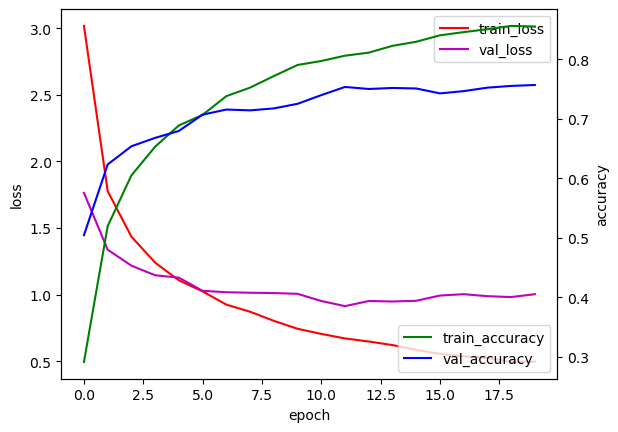

In [14]:
plot_training_progress(results_path)

Precision: 0.7675
Recall: 0.7498
F1 Score: 0.7474


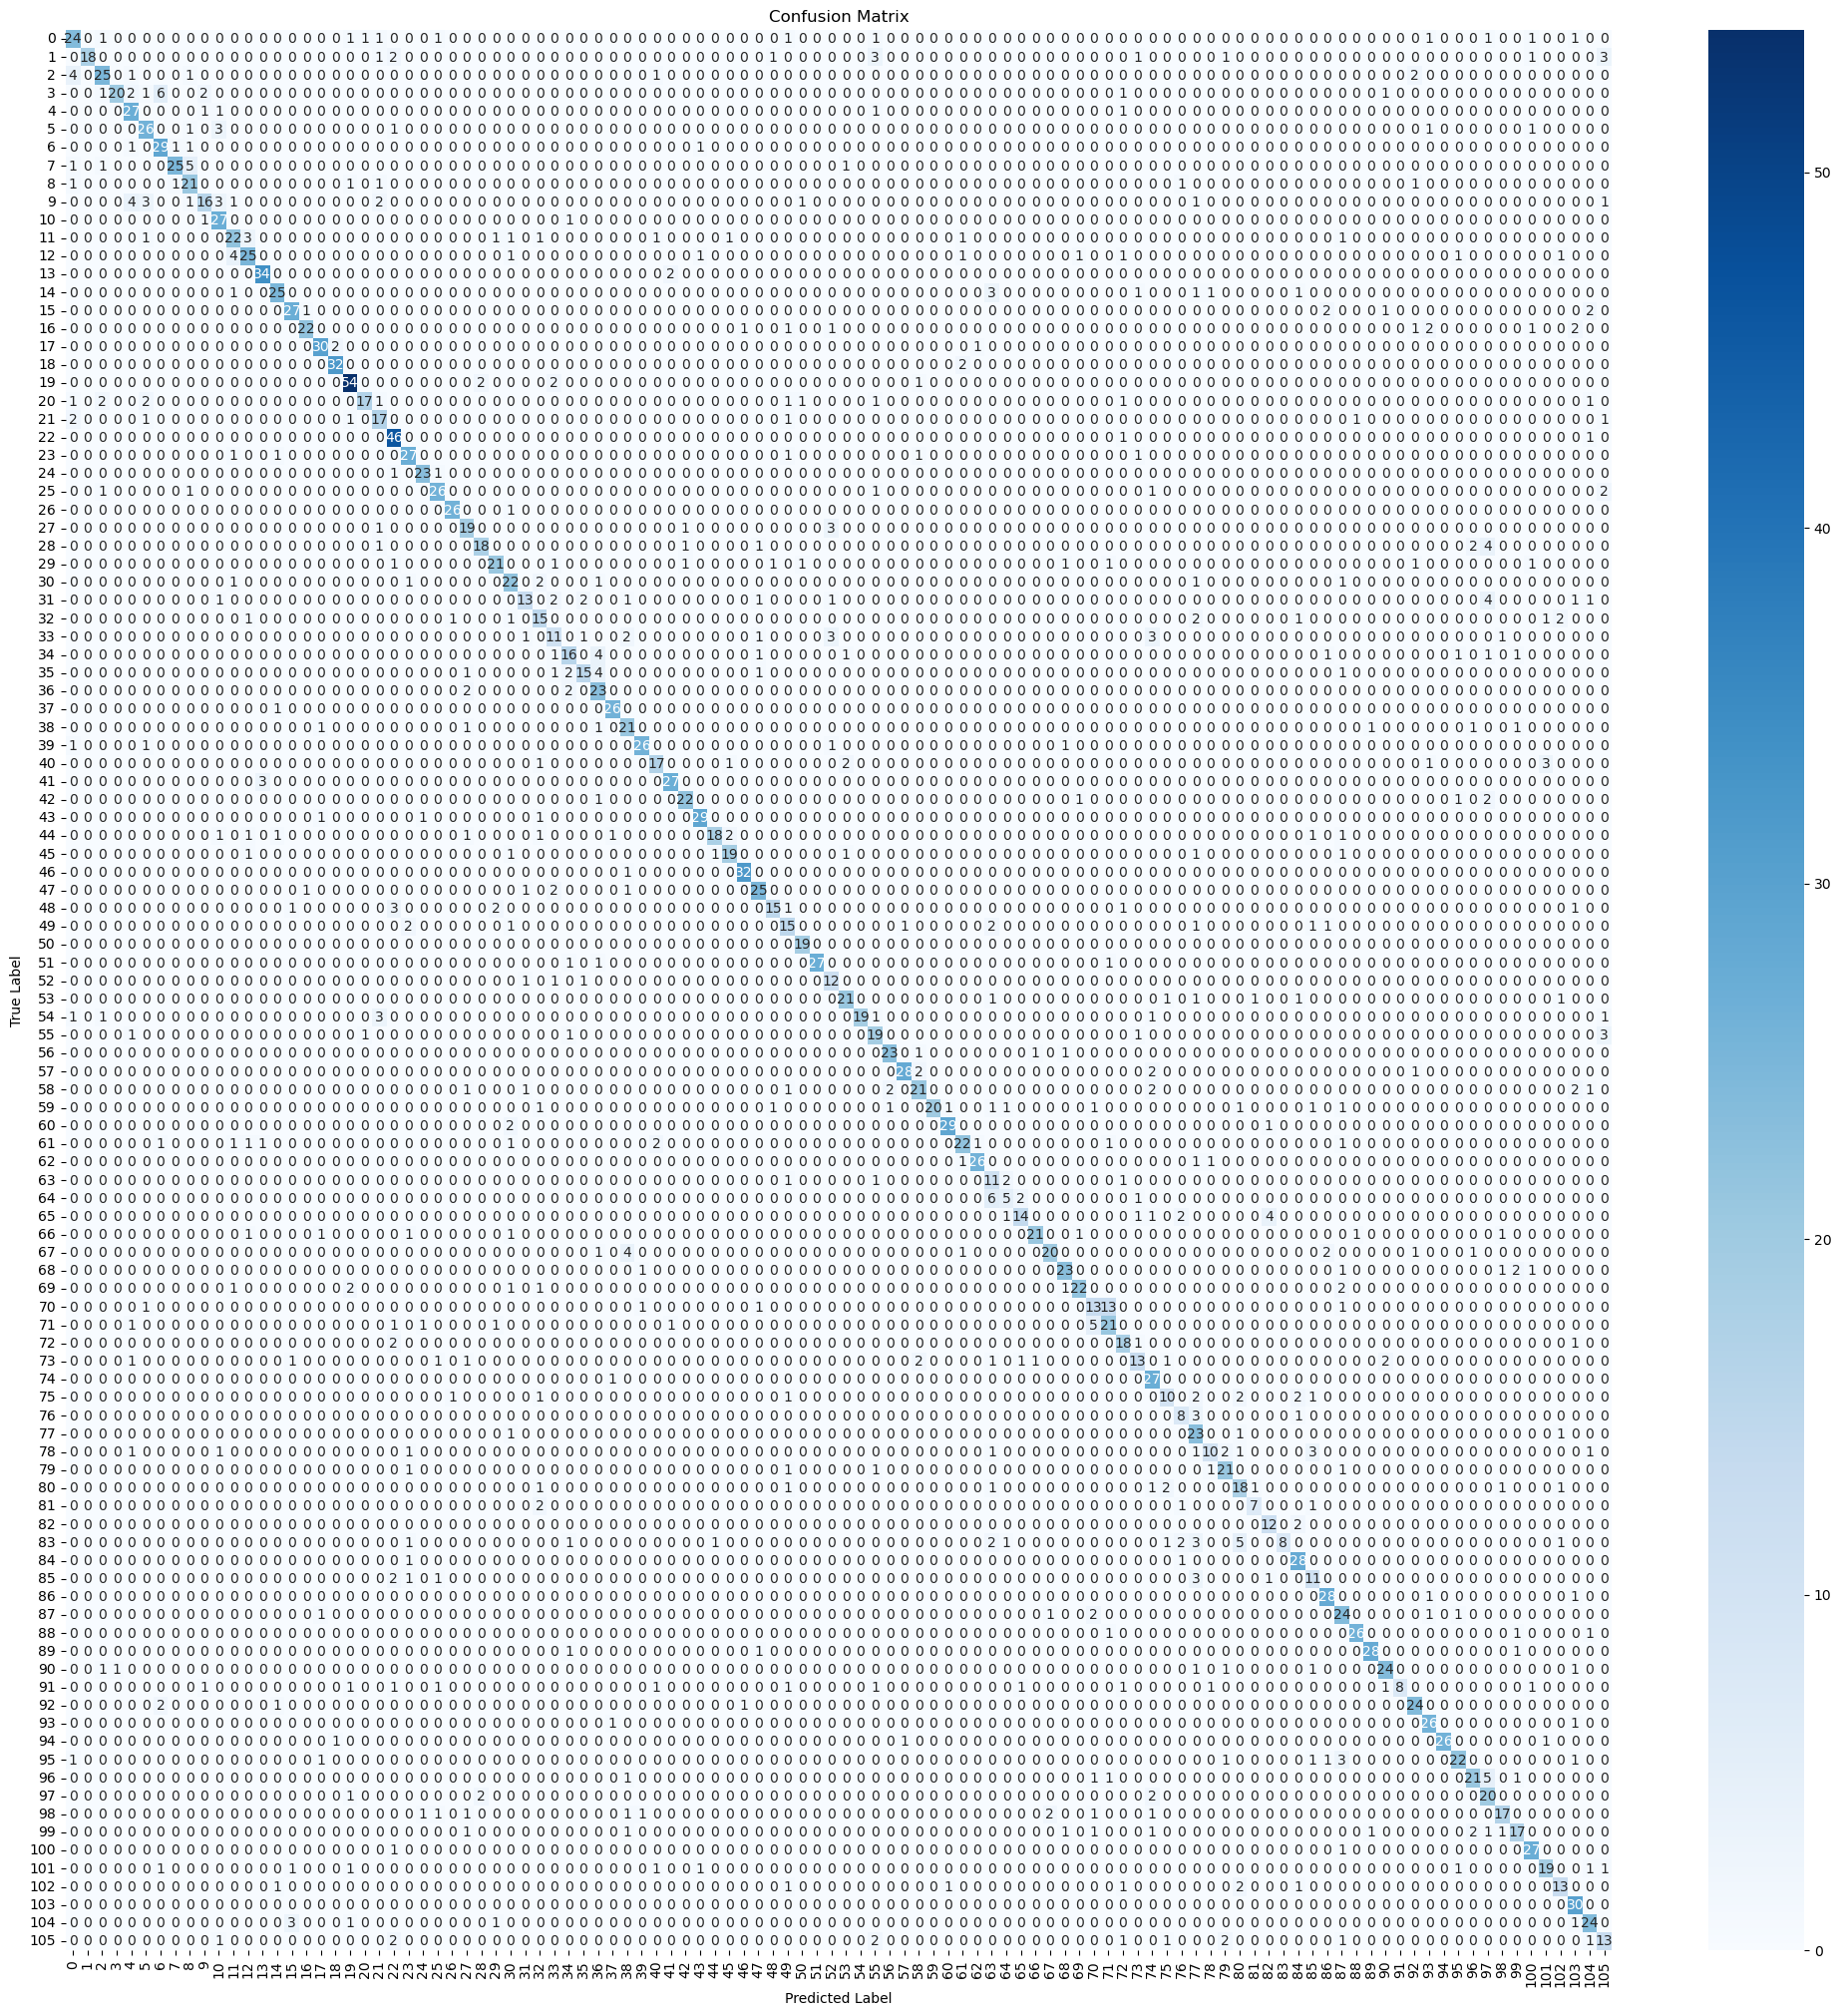

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 加载模型
model = ResNetFIP(num_classes=106)
model.load_state_dict(torch.load(results_path)['model_state_dict'])
model = model.to(device)

# 设置模型为评估模式
model.eval()

# 初始化预测和真实标签的列表
y_true = []
y_pred = []

# 使用模型进行预测
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_true.extend(labels.cpu().numpy().tolist())

# 计算评价指标
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 计算混淆矩阵并进行可视化
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# ResNet - With Image Augmentation - Feature Pyramid Network

In [16]:
torch.cuda.empty_cache()
class ResNetFPN(nn.Module):
    def __init__(self, num_classes):
        super(ResNetFPN, self).__init__()
        
        # Load pretrained ResNet model
        self.backbone = resnet50(pretrained=True)
        
        # Get the output size of different layers in ResNet
        self.conv1 = self.backbone.conv1
        self.bn1 = self.backbone.bn1
        self.relu = self.backbone.relu
        self.maxpool = self.backbone.maxpool
        self.layer1 = self.backbone.layer1
        self.layer2 = self.backbone.layer2
        self.layer3 = self.backbone.layer3
        self.layer4 = self.backbone.layer4
        
        # Use Feature Pyramid Network
        self.fpn = FeaturePyramidNetwork(in_channels_list=[256, 512, 1024, 2048],
                                          out_channels=256)
        
        # Classification layers for each FPN output
        self.fc1 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU())
        self.fc3 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU())
        self.fc4 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU())
        # self.fc1 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU(), nn.Dropout(0.5))
        # self.fc2 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU(), nn.Dropout(0.5))
        # self.fc3 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU(), nn.Dropout(0.5))
        # self.fc4 = nn.Sequential(nn.Linear(256, num_classes), nn.ReLU(), nn.Dropout(0.5))
        
        # Final classification layer
        self.fc_final = nn.Linear(num_classes * 4, num_classes)

        # self.weights = nn.Parameter(torch.ones(4, dtype=torch.float32), requires_grad=True)  # Learnable weights

    def forward(self, x):
        # ResNet part
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        
        # FPN part
        features = self.fpn({"0": x1, "1": x2, "2": x3, "3": x4})
        
        # Classification part
        out1 = self.fc1(F.adaptive_avg_pool2d(features["0"], (1, 1)).view(x.size(0), -1))
        out2 = self.fc2(F.adaptive_avg_pool2d(features["1"], (1, 1)).view(x.size(0), -1))
        out3 = self.fc3(F.adaptive_avg_pool2d(features["2"], (1, 1)).view(x.size(0), -1))
        out4 = self.fc4(F.adaptive_avg_pool2d(features["3"], (1, 1)).view(x.size(0), -1))
        
        # Concatenate the classification results of each FPN output
        out = torch.cat((out1, out2, out3, out4), dim=1)
        # weights = F.softmax(self.weights, dim=0)
        # out = torch.cat([out1 * weights[0], out2 * weights[1], out3 * weights[2], out4 * weights[3]], dim=1)
        
        # Final classification
        out = self.fc_final(out)
        
        return out

    
# time recording start
start_time = time.time()

# Training loop
num_epochs = 25
batch_size = 150
lr = 0.00005

# 分别创建训练集、验证集和测试集的 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定义模型
model = ResNetFPN(num_classes=106)
model = model.to(device)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

# 训练模型
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/10], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # 在每个 epoch 后使用验证集评估模型
    model.eval()
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)
    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"resnet_aug_weightfpn_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)
        
# 所有训练完成后，使用测试集进行最后的评估
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test accuracy: {correct / total * 100}%')


c:\ProgramData\Anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25: Train Loss: 3.6947, Train Accuracy: 0.1773, Val Loss: 2.3794, Val Accuracy: 0.3748
Epoch 2/25: Train Loss: 2.1878, Train Accuracy: 0.4259, Val Loss: 1.7094, Val Accuracy: 0.5253
Epoch 3/25: Train Loss: 1.7515, Train Accuracy: 0.5274, Val Loss: 1.4607, Val Accuracy: 0.5817
Epoch 4/25: Train Loss: 1.5252, Train Accuracy: 0.5835, Val Loss: 1.3336, Val Accuracy: 0.6178
Epoch 5/25: Train Loss: 1.3658, Train Accuracy: 0.6210, Val Loss: 1.2268, Val Accuracy: 0.6477
Epoch 6/25: Train Loss: 1.2311, Train Accuracy: 0.6530, Val Loss: 1.1365, Val Accuracy: 0.6734
Epoch 7/25: Train Loss: 1.1251, Train Accuracy: 0.6865, Val Loss: 1.1188, Val Accuracy: 0.6818
Epoch 8/25: Train Loss: 1.0494, Train Accuracy: 0.7041, Val Loss: 1.0975, Val Accuracy: 0.6882
Epoch 9/25: Train Loss: 0.9591, Train Accuracy: 0.7274, Val Loss: 1.0636, Val Accuracy: 0.6966
Epoch 10/25: Train Loss: 0.9183, Train Accuracy: 0.7400, Val Loss: 1.0634, Val Accuracy: 0.7057
Epoch 11/25: Train Loss: 0.8583, Train Accuracy: 

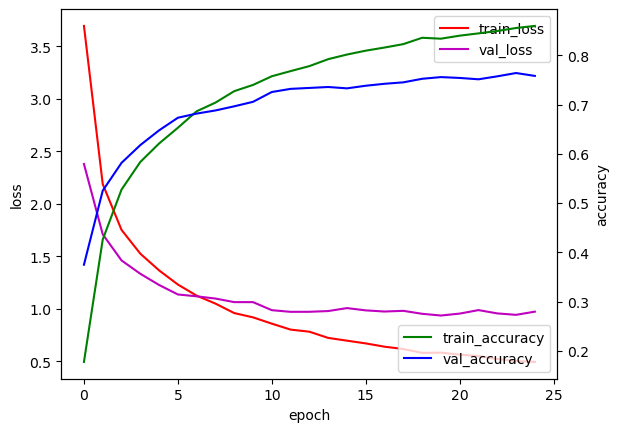

In [17]:
plot_training_progress(results_path)

Precision: 0.7787
Recall: 0.7553
F1 Score: 0.7581


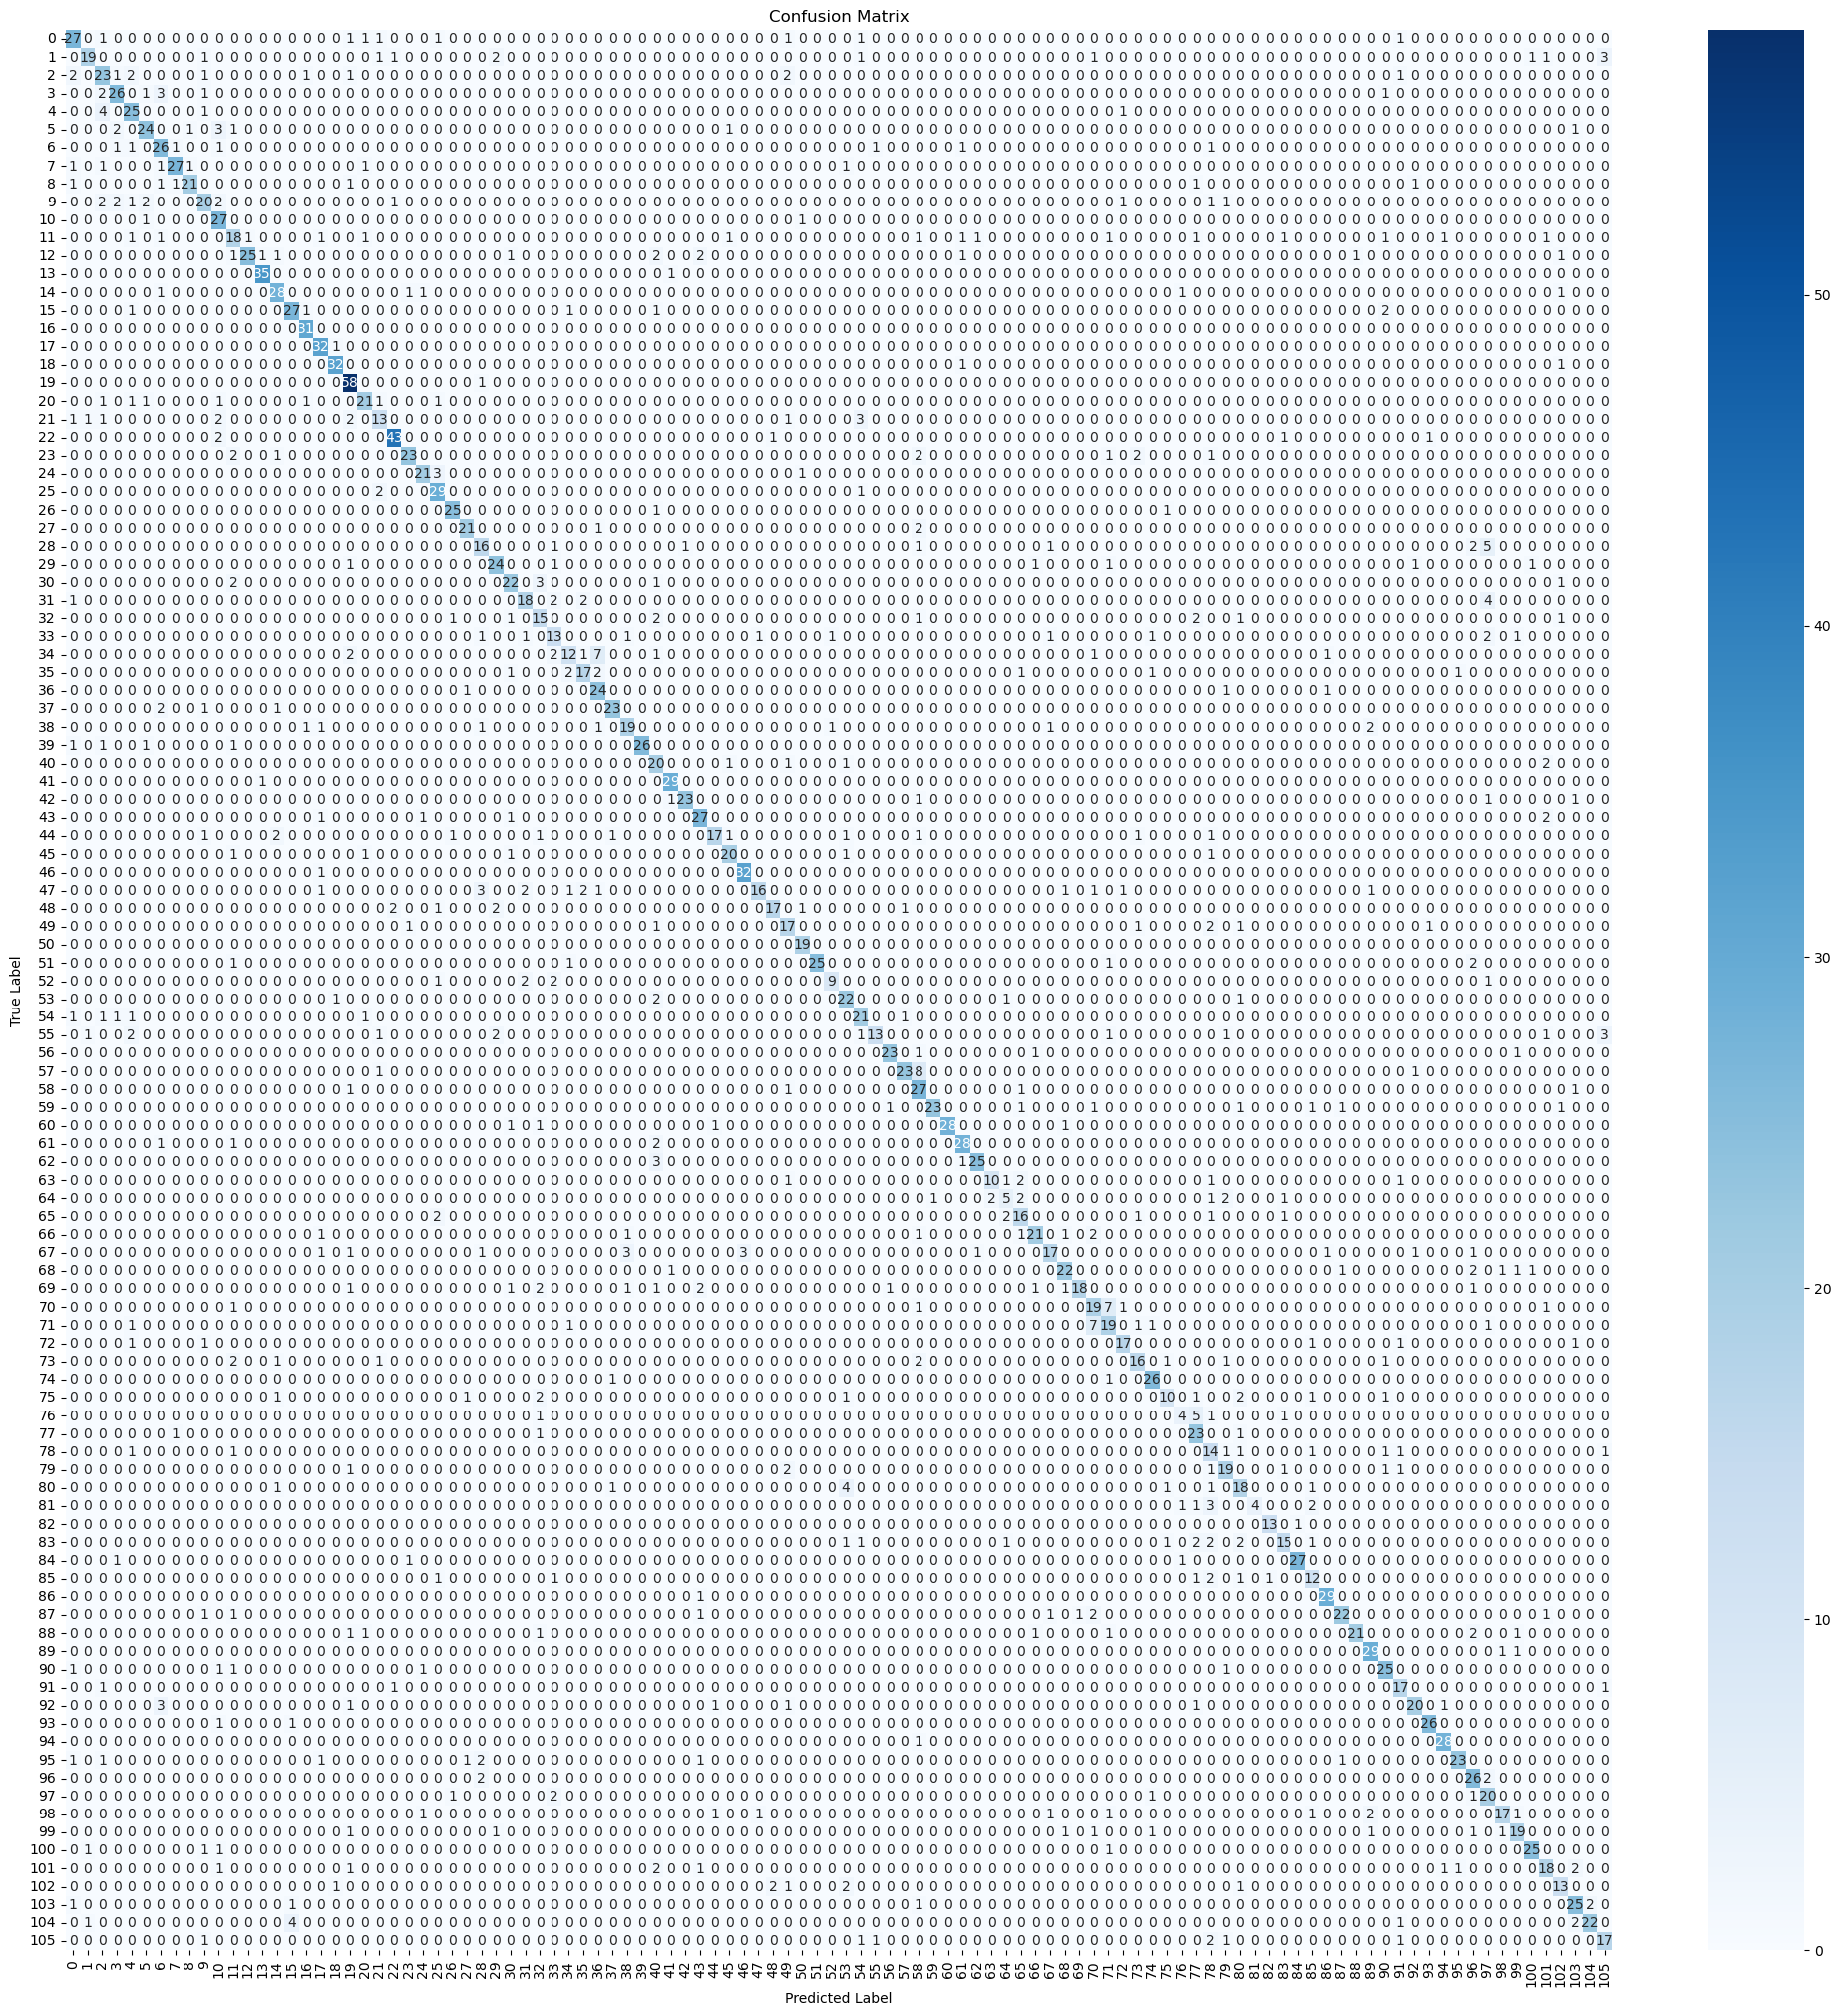

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 加载模型
model = ResNetFPN(num_classes=106)
model.load_state_dict(torch.load(results_path)['model_state_dict'])
model = model.to(device)

# 设置模型为评估模式
model.eval()

# 初始化预测和真实标签的列表
y_true = []
y_pred = []

# 使用模型进行预测
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_true.extend(labels.cpu().numpy().tolist())

# 计算评价指标
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 计算混淆矩阵并进行可视化
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# ResNet - With Image Augmentation - Attention Mechanism

In [5]:
torch.cuda.empty_cache()
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.softmax = nn.Softmax(dim=-2)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        proj_query = self.query_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3]).permute(0,2,1)
        proj_key = self.key_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3])
        attention = self.softmax(torch.bmm(proj_query, proj_key))
        proj_value = self.value_conv(x).view(x.shape[0], -1, x.shape[2]*x.shape[3])
        out = torch.bmm(proj_value, attention.permute(0,2,1)).view(x.shape)
        out = self.gamma*out + x
        return out, attention

class AttentionResNet(nn.Module):
    def __init__(self, num_classes):
        super(AttentionResNet, self).__init__()
        self.resnet = resnet50(pretrained=True)
        self.self_attention = SelfAttention(self.resnet.fc.in_features)
        self.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x, attention_map = self.self_attention(x)
        
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x, attention_map
    
# time recording start
start_time = time.time()

# Training loop
num_epochs = 25
batch_size = 150
lr = 0.00005

# 分别创建训练集、验证集和测试集的 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定义模型
model = AttentionResNet(num_classes=106)
model = model.to(device)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

# 训练模型
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/10], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # 在每个 epoch 后使用验证集评估模型
    model.eval()
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)
    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"resent_attention_aug_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)
        
# 所有训练完成后，使用测试集进行最后的评估
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test accuracy: {correct / total * 100}%')


c:\ProgramData\Anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25: Train Loss: 3.7690, Train Accuracy: 0.2024, Val Loss: 2.6487, Val Accuracy: 0.3997
Epoch 2/25: Train Loss: 2.4064, Train Accuracy: 0.4424, Val Loss: 1.8662, Val Accuracy: 0.5303
Epoch 3/25: Train Loss: 1.8365, Train Accuracy: 0.5429, Val Loss: 1.4781, Val Accuracy: 0.6065
Epoch 4/25: Train Loss: 1.5378, Train Accuracy: 0.6108, Val Loss: 1.2651, Val Accuracy: 0.6603
Epoch 5/25: Train Loss: 1.3313, Train Accuracy: 0.6513, Val Loss: 1.1728, Val Accuracy: 0.6753
Epoch 6/25: Train Loss: 1.1814, Train Accuracy: 0.6891, Val Loss: 1.0734, Val Accuracy: 0.6933
Epoch 7/25: Train Loss: 1.0678, Train Accuracy: 0.7177, Val Loss: 1.0438, Val Accuracy: 0.6997
Epoch 8/25: Train Loss: 0.9827, Train Accuracy: 0.7372, Val Loss: 0.9547, Val Accuracy: 0.7246
Epoch 9/25: Train Loss: 0.9121, Train Accuracy: 0.7535, Val Loss: 0.9422, Val Accuracy: 0.7282
Epoch 10/25: Train Loss: 0.8462, Train Accuracy: 0.7689, Val Loss: 0.8854, Val Accuracy: 0.7436
Epoch 11/25: Train Loss: 0.7870, Train Accuracy: 

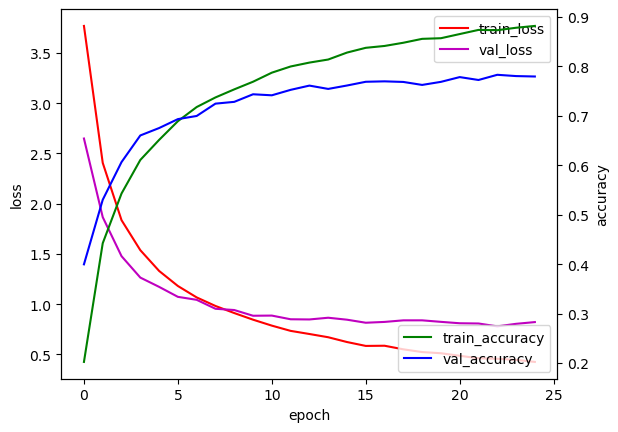

In [6]:
plot_training_progress(results_path)

c:\ProgramData\Anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\MushroomSafe\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Precision: 0.7926
Recall: 0.7731
F1 Score: 0.7754


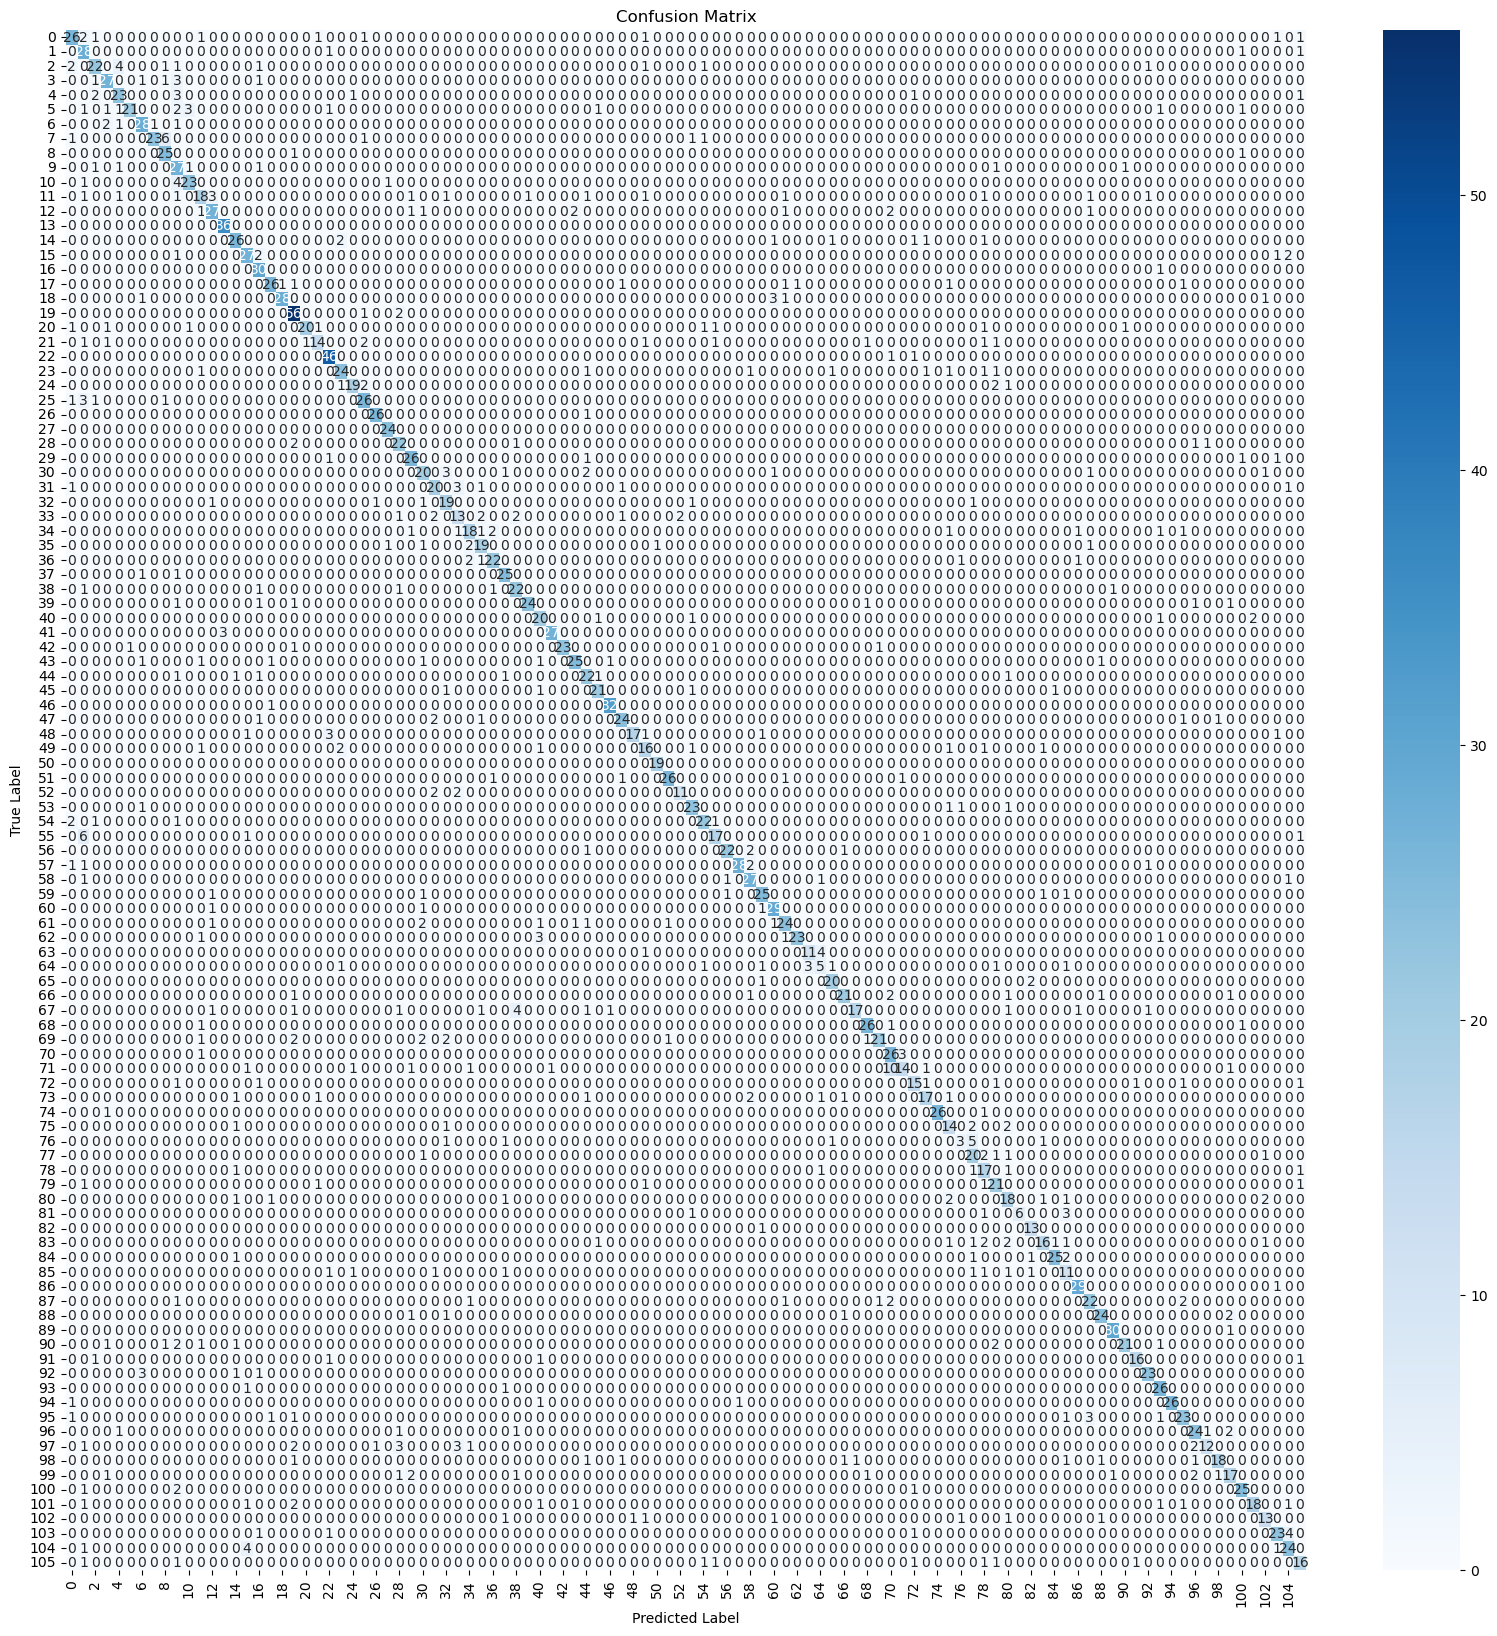

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 加载模型
model = AttentionResNet(num_classes=106)
model.load_state_dict(torch.load(results_path)['model_state_dict'])
model = model.to(device)

# 设置模型为评估模式
model.eval()

# 初始化预测和真实标签的列表
y_true = []
y_pred = []

# 使用模型进行预测
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs, _ = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_true.extend(labels.cpu().numpy().tolist())

# 计算评价指标
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 计算混淆矩阵并进行可视化
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# EfficientNet-B7 - With Image Augmentation

In [10]:
torch.cuda.empty_cache()
from efficientnet_pytorch import EfficientNet

class EfficientNetModel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetModel, self).__init__()

        # 加载预训练的 EfficientNet 模型
        self.backbone = EfficientNet.from_pretrained('efficientnet-b7')

        # 替换最后的全连接层
        self.backbone._fc = nn.Linear(self.backbone._fc.in_features, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        return x
    
# time recording start
start_time = time.time()

# Training loop
num_epochs = 20
batch_size = 32
lr = 0.00005

# 分别创建训练集、验证集和测试集的 DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定义模型
model = EfficientNetModel(num_classes=106)
model = model.to(device)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# initialise ndarray to store the loss and accuracy in each epoch (on the training data)
train_loss = np.zeros(num_epochs)
train_accuracy = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)
val_accuracy = np.zeros(num_epochs)

# 训练模型
best_acc = 0.0
for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # if (i+1) % 100 == 0:
        #     print(f'Epoch [{epoch+1}/10], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

    # 在每个 epoch 后使用验证集评估模型
    model.eval()
    val_loss_epoch = 0.0
    correct_predictions_val = 0
    total_predictions_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item() * images.size(0)

            _, predicted = torch.max(outputs.data, 1)
            correct_predictions_val += (predicted == labels).sum().item()
            total_predictions_val += labels.size(0)
    # Calculate average epoch loss and accuracy
    train_loss[epoch] = running_loss / len(train_dataset)
    train_accuracy[epoch] = correct_predictions / total_predictions
    val_loss[epoch] = val_loss_epoch / len(val_dataset)
    val_accuracy[epoch] = correct_predictions_val / total_predictions_val

    # Print training and validation statistics
    print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss[epoch]:.4f}, Train Accuracy: {train_accuracy[epoch]:.4f}, Val Loss: {val_loss[epoch]:.4f}, Val Accuracy: {val_accuracy[epoch]:.4f}')

end_time = time.time()
total_time = end_time - start_time
print(f"Training took {total_time:.2f} seconds.")

model_metrics = {
    "model_state_dict": model.state_dict(),
    "train_loss": train_loss,
    "train_accuracy": train_accuracy,
    "val_loss": val_loss,
    "val_accuracy": val_accuracy,
    'total_time': total_time
}

# Save the model parameters and metrics to a file
ResultPath = "./results/"
results_path = ResultPath + f"efficientnetb7_aug_epoch{num_epochs}_lr{lr}_bs{batch_size}.pt"

torch.save(model_metrics, results_path)
        
# 所有训练完成后，使用测试集进行最后的评估
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test accuracy: {correct / total * 100}%')


Loaded pretrained weights for efficientnet-b7
Epoch 1/20: Train Loss: 4.0559, Train Accuracy: 0.1418, Val Loss: 2.8325, Val Accuracy: 0.3447
Epoch 2/20: Train Loss: 2.5302, Train Accuracy: 0.3869, Val Loss: 1.8133, Val Accuracy: 0.5384
Epoch 3/20: Train Loss: 1.8602, Train Accuracy: 0.5191, Val Loss: 1.3352, Val Accuracy: 0.6510
Epoch 4/20: Train Loss: 1.5279, Train Accuracy: 0.6012, Val Loss: 1.1154, Val Accuracy: 0.7014
Epoch 5/20: Train Loss: 1.2959, Train Accuracy: 0.6536, Val Loss: 0.9664, Val Accuracy: 0.7303
Epoch 6/20: Train Loss: 1.1237, Train Accuracy: 0.6978, Val Loss: 0.9001, Val Accuracy: 0.7454
Epoch 7/20: Train Loss: 1.0123, Train Accuracy: 0.7273, Val Loss: 0.8500, Val Accuracy: 0.7551
Epoch 8/20: Train Loss: 0.9074, Train Accuracy: 0.7506, Val Loss: 0.7983, Val Accuracy: 0.7709
Epoch 9/20: Train Loss: 0.8252, Train Accuracy: 0.7775, Val Loss: 0.7824, Val Accuracy: 0.7802
Epoch 10/20: Train Loss: 0.7571, Train Accuracy: 0.7908, Val Loss: 0.7319, Val Accuracy: 0.7921
Epo

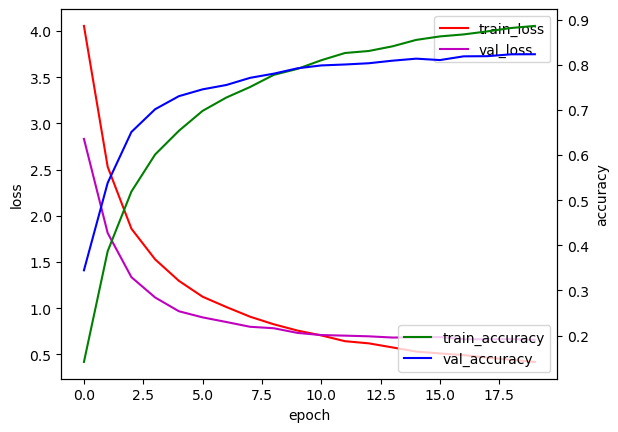

In [11]:
plot_training_progress(results_path)

Loaded pretrained weights for efficientnet-b7
Precision: 0.8198
Recall: 0.8120
F1 Score: 0.8127


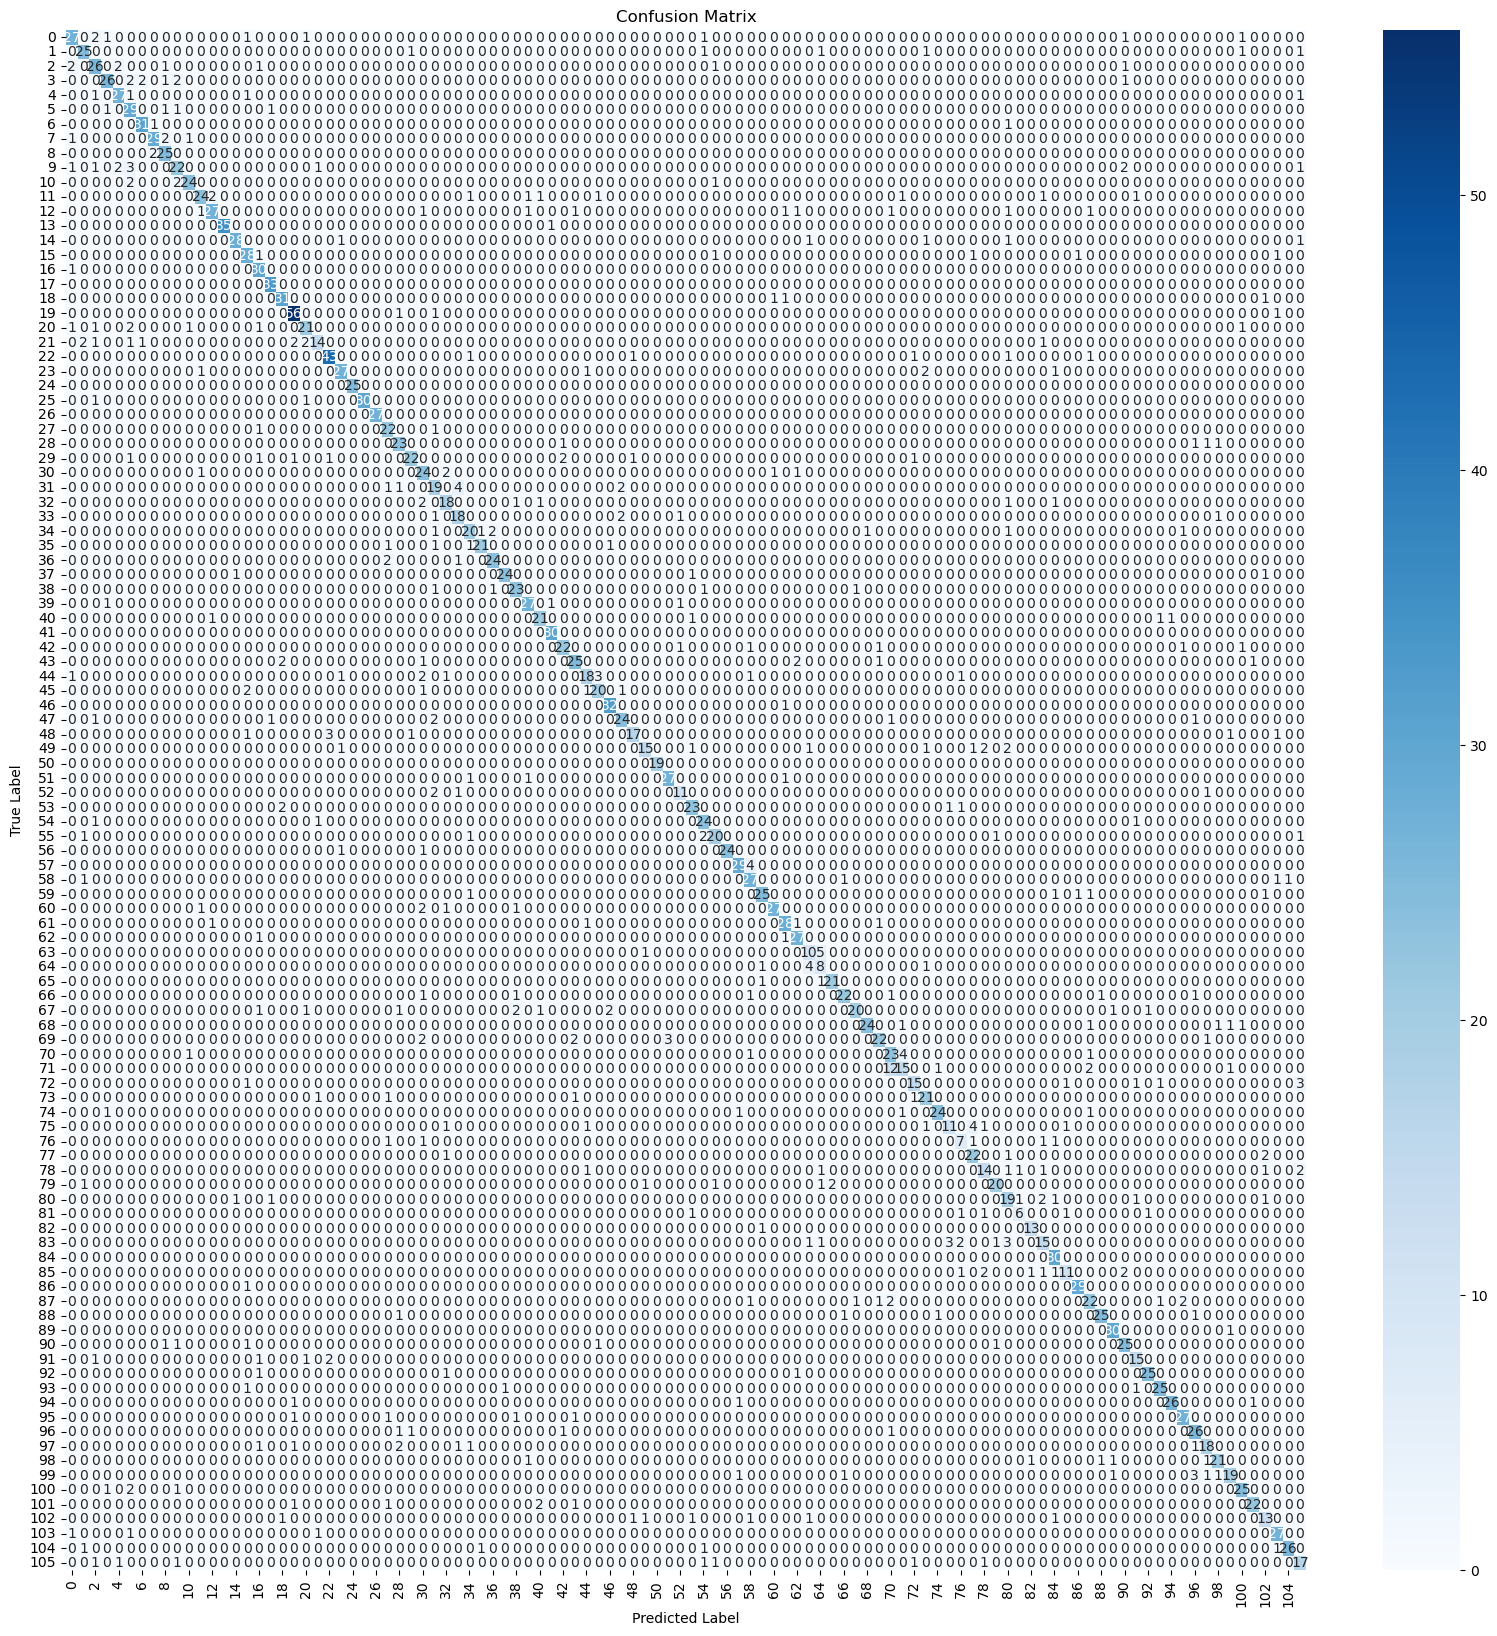

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 加载模型
model = EfficientNetModel(num_classes=106)
model.load_state_dict(torch.load('./results/efficientnetb7_aug_epoch20_lr5e-05_bs32.pt')['model_state_dict'])
model = model.to(device)

# 设置模型为评估模式
model.eval()

# 初始化预测和真实标签的列表
y_true = []
y_pred = []

# 使用模型进行预测
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy().tolist())
        y_true.extend(labels.cpu().numpy().tolist())

# 计算评价指标
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 计算混淆矩阵并进行可视化
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
